In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'
             }


In [3]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

In [4]:
assert train_x.shape == (50000, 32, 32, 3)
assert test_x.shape == (10000, 32, 32, 3)
assert train_y.shape == (50000, 1)
assert test_y.shape == (10000, 1)

In [5]:
train_x = train_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.
test_x = test_x.reshape(-1, 32, 32, 3).astype(np.float32) / 255.

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


In [6]:
train_y

array([6, 9, 9, ..., 9, 1, 1])

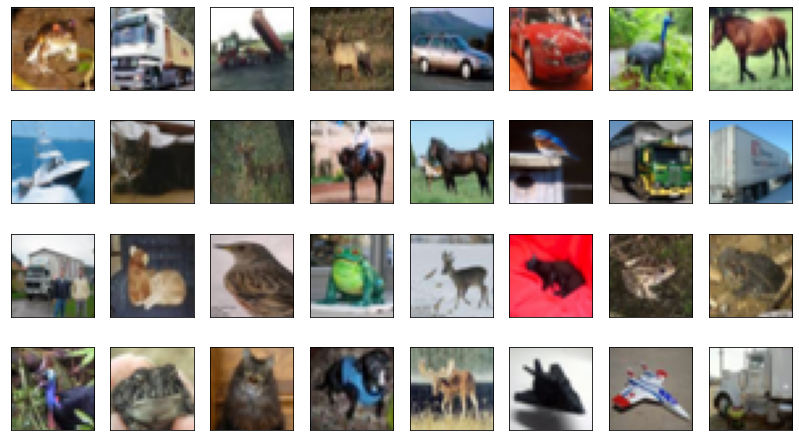

In [7]:
some_samples = train_x[:32, ...]

fig = plt.figure(figsize=(14, 8))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,:,:,:])
    plt.xticks([]), plt.yticks([])
plt.show()

In [8]:
NUM_EPOCHS = 4
BATCH_SIZE = 64

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))

train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])

train_ds = train_ds.repeat(NUM_EPOCHS)

train_ds = train_ds.batch(BATCH_SIZE)

In [9]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(10, activation=None)
        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, inp):
        out = self.conv1(inp)
        out = self.max_pool(out)
        out = self.conv2(out)
        out = self.max_pool(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.fc2(out)
        
        return out

model = Model()

In [10]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [11]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

writer = tf.summary.create_file_writer('logs/adam7')

In [12]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    if iteration % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        print("[%4d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))
        
        with writer.as_default():
            tf.summary.scalar('accuracy', accuracy_value, iteration)
            tf.summary.scalar('loss', loss_value, iteration)

[   0] Accuracy:  7.81 %
[ 200] Accuracy: 40.23 %
[ 400] Accuracy: 51.95 %
[ 600] Accuracy: 56.25 %
[ 800] Accuracy: 59.38 %
[1000] Accuracy: 62.89 %
[1200] Accuracy: 63.67 %
[1400] Accuracy: 63.67 %
[1600] Accuracy: 62.89 %
[1800] Accuracy: 66.41 %
[2000] Accuracy: 66.41 %
[2200] Accuracy: 64.06 %
[2400] Accuracy: 68.36 %
[2600] Accuracy: 67.58 %
[2800] Accuracy: 69.92 %
[3000] Accuracy: 67.19 %
Wall time: 4min 29s


In [13]:
%%time

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print("Final Accuracy: %5.2f %%" % (accuracy_value * 100))

Final Accuracy: 68.66 %
Wall time: 3.2 s


In [14]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 5568), started 1 day, 0:32:15 ago. (Use '!kill 5568' to kill it.)

# Функция для инференса и отображения результата предсказания

In [15]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[:,:,], cmap='gray')
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print(f'Predicted: {ans} - {class_dict[ans]} ')

# Запуск предсказания для изображения случайной цифры

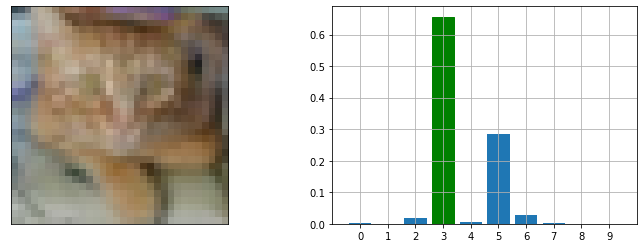

Predicted: 3 - cat 
True Answer: 3 -  cat


In [25]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print(f'True Answer: {test_y[idx]} -  {class_dict[test_y[idx]]}')